In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load packages

In [ ]:
import json
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,wordpunct_tokenize
from nltk.stem import PorterStemmer
import tqdm
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from collections import Counter
import csv

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import SGD
import torch.nn.functional as F

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Initialize utils

In [ ]:
#Set root directory
root_dir="/content/drive/MyDrive/DS/2ANNO/NLP/Bonus/EX1/"
os.chdir(root_dir)

#Load pretrained Word2Vec model
wv = api.load('word2vec-google-news-300')

#Define stopwords
stop_words = set(stopwords.words('english'))

#EDA

First things first, we perform some exploratory data analysis on top of our data to asses wheter datapoints are uniformly distributed over the 15 different classes or not. Also, code is provided to extract the probability masses of the top-k most frequent words in our trining set. As it turns out, datapoints are not uniformly spread on top of all the possible classes: because of that, we have to keep in mind that our accuracy score will just be a biased descriptor of our model performance. 

In [ ]:
def EDA(file_name,labels):
  
  classes_distribution=np.zeros(len(labels))
  word_distribution={}

  with open(file_name) as file:
    #Open file to assess number of data samples
    n_lines = sum(1 for _ in file)

  with open(file_name) as file:
    #Initialize progress bar
    with tqdm.tqdm(total=n_lines) as pbar:
      #Read line by line (datapoint by datapoint)
      for line in file:
        #Update progress bar
        pbar.update(1)        
        
        #Read line in json format
        sample=json.loads(line)
        
        #Word tokenike each "text" corpus
        tokens=wordpunct_tokenize(sample["text"])
        
        for word in tokens:
            #Update word distribution
            if word in word_distribution:
              word_distribution[word]+=1
            else:
              word_distribution[word]=1  

        
        #Update classes distribution     
        classes_distribution[labels.index(sample["label"])]+=1

  #Normalize classes distribution
  classes_distribution/=n_lines

  #Normalize word distribution
  total_words=sum(word_distribution.values())
  word_distribution = {k: v / total_words for k, v in word_distribution.items()}
  return classes_distribution,  word_distribution,  total_words

In [ ]:
#Define type of labels that can be seen
labels=["business", "crime", "culture/arts", "education",
        "entertainment", "environment", "food/drink", 
        "home/living", "media", "politics", "religion",
        "sci/tech", "sports", "wellness", "world"]

class_distr, word_distr, total_words  = EDA("train.jsonl",labels)

100%|██████████| 186282/186282 [00:09<00:00, 20643.57it/s]


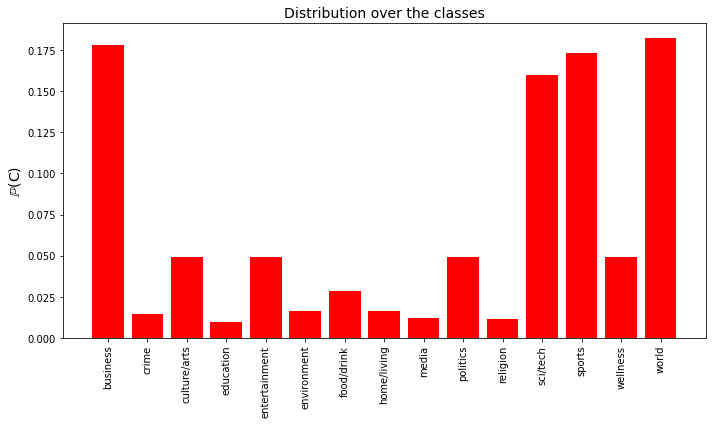

In [ ]:
plt.figure(figsize=(10,6), tight_layout=True)
x=np.arange(15)

# Set x-ticks for x-axis
plt.xticks(ticks = x ,labels = labels, rotation = "vertical")
plt.ylabel('$\mathbb{P}$(C)',fontsize=14)

plt.bar(x, class_distr,color="red")
plt.title('Distribution over the classes',fontsize=14)
plt.show()

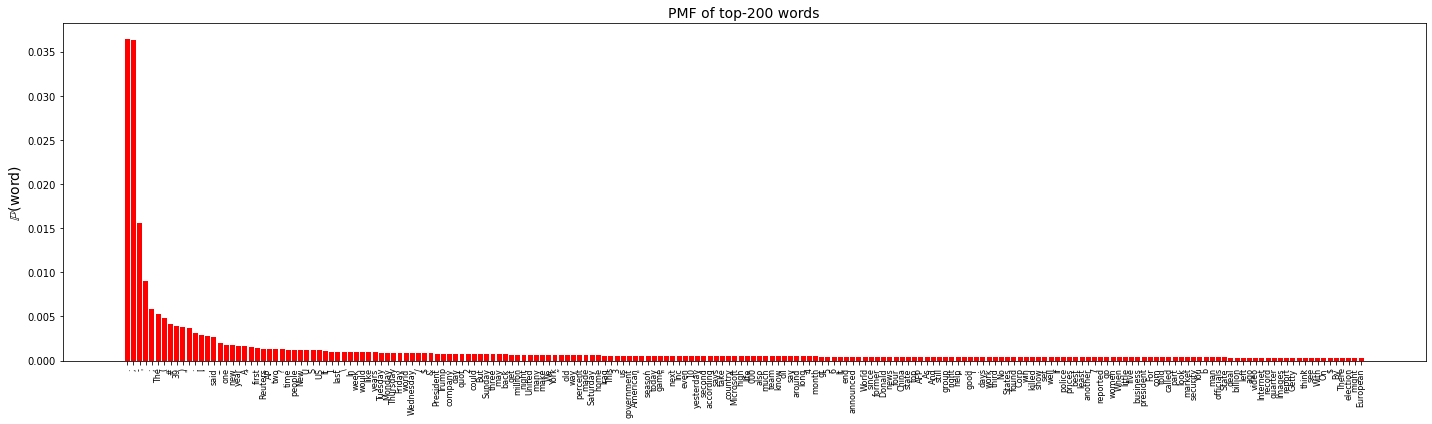

In [ ]:
#Retrieve distribution of top-k most fequent words
k=200
ordered_words = Counter(word_distr).most_common(total_words)

#Extract words and probabilities
words=[key_value[0] for key_value in ordered_words if not key_value[0] in stop_words]
probs=[key_value[1] for key_value in ordered_words if not key_value[0] in stop_words]

plt.figure(figsize=(20,6), tight_layout=True)

# Set x-ticks for x-axis
plt.xticks(ticks = np.arange(k) ,labels = words[:k], rotation = "vertical",fontsize=8)
plt.ylabel('$\mathbb{P}$(word)',fontsize=14)

plt.bar(np.arange(k), probs[:k],color="red")
plt.title('PMF of top-{} words'.format(k),fontsize=14)
plt.show()

#Read data and preprocess text (Lowering, stopwords/punctuation removal, features word2vec embedding)

After the EDA, we want to tackle the true preprocessing step. Each text corpus (for each datapoint) is word-tokenized: each word-token is lowered and removed if belonging to punctuation set or nltk.stop_words set and finally embedded in $\mathbb{R}^{300}$ by a pretrained word2vec model.  

In [ ]:
def load_preprocess_embed_onehot_data(file_name,labels):
  print("\nLoading and preprocessing '{}'..".format(file_name))
  with open(file_name) as file:
    #Open file to assess number of data samples
    n_lines = sum(1 for _ in file)

  with open(file_name) as file:
    #Initialize progress bar
    with tqdm.tqdm(total=n_lines) as pbar:
      data = []
      #Read line by line (datapoint by datapoint)
      for line in file:
        #Update progress bar
        pbar.update(1)        
        
        #Read line in json format
        sample=json.loads(line)
        
        #Word tokenike each "text" corpus
        tokens=wordpunct_tokenize(sample["text"])
        
        #Preprocess each corpus
        sample["text"]=[w.lower() for w in tokens if not w.lower() in stop_words if w.isalpha()]

        #Embed each of the word in the text corpus and add to the general embedding for "text".
        #The try/except deal with all the words that can't be found by the pretrained word2vec model
        text_embedding=0
        for word in sample["text"]:
            try:
              word_embedding=wv[word]
              text_embedding+=wv[word]
            except:
              pass
        sample["text"]=text_embedding

        #Numerical encode the labels     
        if "label" in sample:
          sample["label"]=labels.index(sample["label"])
        data.append(sample)
  return data

In [ ]:
#Load all the data. Preprocessing, embedding and numerical encoding of the labels is performed
train_data  = load_preprocess_embed_onehot_data("train.jsonl",labels)
test_data   = load_preprocess_embed_onehot_data("test.jsonl",labels)
val_data    = load_preprocess_embed_onehot_data("dev.jsonl",labels)


Loading and preprocessing 'train.jsonl'..


100%|██████████| 186282/186282 [00:47<00:00, 3904.26it/s]



Loading and preprocessing 'test.jsonl'..


100%|██████████| 6849/6849 [00:01<00:00, 4342.16it/s]



Loading and preprocessing 'dev.jsonl'..


100%|██████████| 6844/6844 [00:01<00:00, 3713.21it/s]


In [ ]:
# Print an example of training and test datapoints
print(train_data[0],test_data[0])

{'text': array([-0.19128418,  1.2373962 , -0.96139526,  0.7142029 , -0.9695587 ,
       -1.4402466 ,  0.74365234, -1.8470459 ,  1.4620876 ,  1.1494141 ,
       -1.4512253 , -2.1062012 , -0.97021484,  1.0907607 , -4.3477173 ,
        1.406311  ,  0.8886719 ,  2.270996  , -0.9661865 , -0.21054077,
       -2.0185547 ,  1.548523  ,  1.6785736 ,  0.8260689 ,  1.3491821 ,
       -1.258667  , -2.308838  ,  1.3684082 , -2.1677094 ,  0.7460327 ,
        0.43136597, -0.06430817, -2.2913055 ,  0.6234436 ,  0.2859497 ,
       -0.14428711,  0.4126892 ,  1.0039673 ,  1.8383789 ,  0.454422  ,
        1.6264343 , -1.2329712 ,  1.7687988 , -1.0243225 , -0.66264343,
       -2.8876953 , -1.1567078 ,  0.7139282 ,  0.1149292 ,  1.0991211 ,
       -0.8605957 ,  0.20495605, -0.12664795, -0.2870636 ,  0.26976013,
        1.7861328 , -1.3252258 , -1.720581  ,  0.6851196 , -1.6090572 ,
        0.7916031 ,  2.3145142 , -1.7306366 ,  0.28045654, -0.9680176 ,
       -0.04250813, -0.88116455, -0.04663086,  0.529289

In [ ]:
class SentencesDataset(Dataset):

    """Face Landmarks dataset."""
    def __init__(self, data):
        self.data = data
                        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.data[idx]["text"])
        id        = self.data[idx]["id"]
        # Since the test set doesn't contain labels,
        # Assign a fake label to each test set datapoint
        try:
          label   = self.data[idx]["label"]
        except:
          label   = torch.tensor([99])

        return embedding,label,id

In [ ]:
#Define the datasets
train_dataset = SentencesDataset(train_data)
val_dataset   = SentencesDataset(val_data)
test_dataset  = SentencesDataset(test_data)

#Define batch size
BATCH_SIZE=32

#Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader   = DataLoader(val_dataset,batch_size=1)
test_dataloader  = DataLoader(test_dataset, batch_size=1)

#Build the model

The implemented model is a simple 2 layer neural network: it has 300 (equal to the dimension of the word2vec embeddings) input neurons, 100 hidden neurons and 15 (equal to the number of distinct classes) output neurons. ReLu activation function has been used between the first and the second fully connected layer.

By the inner nature of the problem, CrossEntropy is the chosen loss. Instead of the usual SGD optimizer, I decided to exploit the Adam optimizer.

In [ ]:
# Define a class to build a simple 2 layer neural network. #features, #hidden neurons
# and #classes are fed once initializing the instance of the class.

class TwoLayerClassifier(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(TwoLayerClassifier, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        logit = self.fc2(x)
        
        return logit

In [ ]:
# The pretrained word2vec produces embeddings in R^300
n_features=300

# Define number of hidden neurons and classes
n_hidden=100
n_classes=len(labels)

# Initialize the instance of the model
model = TwoLayerClassifier(n_features,n_hidden,n_classes)

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Build per-epoch training loop. Both the train_one_epoch() and the training 
# loop have been inspired by the official documentation of torch package.
 
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # For all the batches in our train dataloader:
    for i, data in enumerate(train_dataloader):
        # Every data batch contains features+labels+id
        features, labels ,id = data

        # Initialize gradients for each batch
        optimizer.zero_grad()

        # Make predictions over the batch batch
        outputs = model(features)

        # Compute CE loss and gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Execute update of the weights
        optimizer.step()

        # Print per-batch loss
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [ ]:
# Build the training loop. Both the train_one_epoch() and the training 
# loop have been inspired by the official documentation of torch package.

EPOCHS = 30

# Initialize 2 empty lists to store training and 
# validations losses during training phase
train_loss=[]
val_loss=[]

best_val_loss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Keep gradients on while performing the training step
    model.train(True)
    avg_loss = train_one_epoch(epoch)
    
    # Switch off gradients to assess performance over the validation set
    model.train(False)

    running_val_loss = 0.0
    for i, val_data in enumerate(val_dataloader):
        # Every val_data batch contains features+labels+id
        val_features, val_labels, val_id = val_data
        # Compute model's outputs
        val_outputs = model(val_features)
        # Compute loss function value
        vloss = loss_fn(val_outputs, val_labels)
        running_val_loss += vloss

    avg_val_loss = running_val_loss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_val_loss))

    train_loss.append(avg_loss)
    val_loss.append(avg_val_loss.item())
    
    # Track best performance, and save the model's state
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_path = 'best_val_model'
        torch.save(model.state_dict(), model_path)

EPOCH 1:
  batch 1000 loss: 1.394202490746975
  batch 2000 loss: 0.8794220304489135
  batch 3000 loss: 0.8094229532629251
  batch 4000 loss: 0.7941064953207969
  batch 5000 loss: 0.7756479449868202
LOSS train 0.7756479449868202 valid 0.9071632027626038
EPOCH 2:
  batch 1000 loss: 0.7318552647680044
  batch 2000 loss: 0.7343400476276875
  batch 3000 loss: 0.7191306190341711
  batch 4000 loss: 0.7271574143767356
  batch 5000 loss: 0.7202862566411495
LOSS train 0.7202862566411495 valid 0.8700330257415771
EPOCH 3:
  batch 1000 loss: 0.6882764758616686
  batch 2000 loss: 0.6940821071863175
  batch 3000 loss: 0.683921553760767
  batch 4000 loss: 0.6949773454219103
  batch 5000 loss: 0.6898700620532036
LOSS train 0.6898700620532036 valid 0.8467699289321899
EPOCH 4:
  batch 1000 loss: 0.6614734501242637
  batch 2000 loss: 0.667768898576498
  batch 3000 loss: 0.6604168802648783
  batch 4000 loss: 0.6728715428709984
  batch 5000 loss: 0.6674821377396584
LOSS train 0.6674821377396584 valid 0.8300

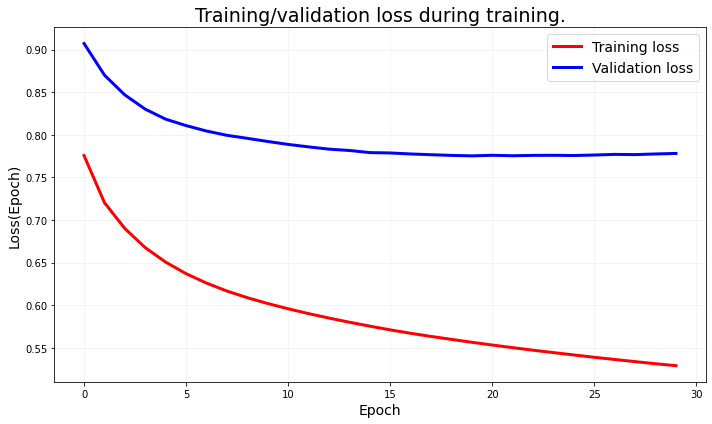

In [ ]:
# Print intra-learning losses
plt.figure(figsize=(10,6), tight_layout=True)
plt.plot(np.arange(EPOCHS),train_loss, linewidth=3,color="red")
plt.plot(np.arange(EPOCHS),val_loss, linewidth=3,color="blue")

plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss(Epoch)',fontsize=14)
plt.title(('Training/validation loss during training.'),fontsize=19)
plt.legend(labels=['Training loss',"Validation loss"],fontsize=14)
plt.grid(axis='x', color='0.95')
plt.grid(axis='y', color='0.95')
plt.show()

In [ ]:
#Reload the best model
model.load_state_dict(torch.load("best_val_model"))

<All keys matched successfully>

In [ ]:
# Perform the predictions over the test set
with open('test.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    for i, test_data in enumerate(test_dataloader):
      # Every test_data batch contains features+id+fake_label
      test_features,test_fake_label,test_id= test_data
      # Compute model's outputs
      test_outputs = model(test_features)
      writer.writerow([test_id.item(), labels[torch.argmax(test_outputs).item()]])